In [1]:
import os
import cv2
import shutil
import numpy as np

In [6]:
TRAIN_DIR = "./train"
TRAIN_CLEAN_DIR = "./train_clean1"
BRIGHT_DIR = "./data1/bright_images"
FIXED_DIR  = "./data1/fixed_images"

os.makedirs(TRAIN_CLEAN_DIR, exist_ok=True)
os.makedirs(BRIGHT_DIR, exist_ok=True)
os.makedirs(FIXED_DIR, exist_ok=True)

BRIGHT_PIXEL_THRESHOLD = 245
BRIGHT_RATIO_THRESHOLD = 0.3

In [ ]:
def is_very_bright(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ratio = np.sum(gray >= BRIGHT_PIXEL_THRESHOLD) / gray.size
    return ratio > BRIGHT_RATIO_THRESHOLD

def is_medium_bright(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ratio = np.sum(gray >= BRIGHT_PIXEL_THRESHOLD) / gray.size
    return 0.05 < ratio <= BRIGHT_RATIO_THRESHOLD

def is_blurry(img, thresh=120):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(gray, cv2.CV_64F).var() < thresh

In [8]:
def fix_image(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)

    l = np.clip(l * 0.85, 0, 255).astype(np.uint8)
    clahe = cv2.createCLAHE(clipLimit=1.2, tileGridSize=(8,8))
    l = clahe.apply(l)

    img = cv2.merge((l, a, b))
    img = cv2.cvtColor(img, cv2.COLOR_LAB2BGR)

    blur = cv2.GaussianBlur(img, (0,0), 1.0)
    img = cv2.addWeighted(img, 1.3, blur, -0.3, 0)

    return img


In [9]:
stats = {
    "too_bright": 0,
    "fixed": 0,
    "normal": 0
}

for cls in os.listdir(TRAIN_DIR):
    cls_path = os.path.join(TRAIN_DIR, cls)
    if not os.path.isdir(cls_path):
        continue

    out_bright = os.path.join(BRIGHT_DIR, cls)
    out_fixed  = os.path.join(FIXED_DIR, cls)
    out_clean  = os.path.join(TRAIN_CLEAN_DIR, cls)

    os.makedirs(out_bright, exist_ok=True)
    os.makedirs(out_fixed, exist_ok=True)
    os.makedirs(out_clean, exist_ok=True)

    for img_name in os.listdir(cls_path):
        if not img_name.lower().endswith((".jpg",".jpeg",".png")):
            continue

        src = os.path.join(cls_path, img_name)
        img = cv2.imread(src)
        if img is None:
            continue

        # 1️⃣ ẢNH QUÁ CHÓI → COPY SANG BRIGHT
        if is_very_bright(img):
            shutil.copy(src, os.path.join(out_bright, img_name))
            stats["too_bright"] += 1
            continue

        # 2️⃣ ẢNH CHÓI VỪA / MỜ → FIX → LƯU FIX + TRAIN_CLEAN
        if is_medium_bright(img) or is_blurry(img):
            img_fixed = fix_image(img)
            cv2.imwrite(os.path.join(out_fixed, img_name), img_fixed)
            cv2.imwrite(os.path.join(out_clean, img_name), img_fixed)
            stats["fixed"] += 1

        # 3️⃣ ẢNH BÌNH THƯỜNG → COPY SANG TRAIN_CLEAN
        else:
            shutil.copy(src, os.path.join(out_clean, img_name))
            stats["normal"] += 1

In [10]:
print("SỐ ẢNH QUÁ CHÓI THEO TỪNG LỚP:")

for cls in sorted(os.listdir(BRIGHT_DIR)):
    cls_path = os.path.join(BRIGHT_DIR, cls)
    if not os.path.isdir(cls_path):
        continue

    count = len([
        f for f in os.listdir(cls_path)
        if f.lower().endswith((".jpg", ".jpeg", ".png"))
    ])

    print(f"{cls}: {count} ảnh chói")


SỐ ẢNH QUÁ CHÓI THEO TỪNG LỚP:
Apple___Apple_scab: 0 ảnh chói
Apple___Black_rot: 0 ảnh chói
Apple___Cedar_apple_rust: 200 ảnh chói
Apple___healthy: 0 ảnh chói
Blueberry___healthy: 173 ảnh chói
Cherry_(including_sour)___Powdery_mildew: 0 ảnh chói
Cherry_(including_sour)___healthy: 0 ảnh chói
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0 ảnh chói
Corn_(maize)___Common_rust_: 0 ảnh chói
Corn_(maize)___Northern_Leaf_Blight: 0 ảnh chói
Corn_(maize)___healthy: 0 ảnh chói
Grape___Black_rot: 0 ảnh chói
Grape___Esca_(Black_Measles): 0 ảnh chói
Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 0 ảnh chói
Grape___healthy: 0 ảnh chói
Orange___Haunglongbing_(Citrus_greening): 0 ảnh chói
Peach___Bacterial_spot: 0 ảnh chói
Peach___healthy: 281 ảnh chói
Pepper,_bell___Bacterial_spot: 0 ảnh chói
Pepper,_bell___healthy: 205 ảnh chói
Potato___Early_blight: 0 ảnh chói
Potato___Late_blight: 0 ảnh chói
Potato___healthy: 125 ảnh chói
Raspberry___healthy: 294 ảnh chói
Soybean___healthy: 2 ảnh chói
Squash___

In [11]:
print(f"\nTỔNG KẾT:")
print(f"Tổng ảnh quá chói: {stats['too_bright']}")
print(f"Tổng ảnh được fix: {stats['fixed']}")
print(f"Tổng ảnh bình thường: {stats['normal']}")
print(f"Tổng ảnh dùng để trainning: {stats['fixed'] + stats['normal']}")


TỔNG KẾT:
Tổng ảnh quá chói: 1919
Tổng ảnh được fix: 2265
Tổng ảnh bình thường: 66111
Tổng ảnh dùng để trainning: 68376


In [23]:
import tensorflow as tf
from tensorflow.keras import preprocessing

train_dir = "./train_clean1"
valid_dir = "./valid"
test_dir  = "./test"

img_size = (224, 224)
batch_size = 32

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir, 
    image_size=img_size, 
    batch_size=batch_size
)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir, 
    image_size=img_size, 
    batch_size=batch_size
)

Found 68376 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


In [24]:
class_names = train_ds.class_names
num_classes = len(class_names)

print("Number of classes:", num_classes)
print("Classes:", class_names)

Number of classes: 38
Classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_sp

In [47]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.08),
    tf.keras.layers.RandomBrightness(0.2),
    tf.keras.layers.RandomZoom(0.08),
    tf.keras.layers.RandomContrast(0.1),
])

In [48]:
# Áp dụng tăng cường dữ liệu cho tập huấn luyện
def augment_train(image, label):
    image = data_augmentation(image, training=True)
    return image, label

train_ds_aug = train_ds.map(
    augment_train,
    num_parallel_calls=1
)


In [52]:
base_model = tf.keras.applications.MobileNetV3Large(
    input_shape=(224,224,3),
    include_top=False,
    weights="imagenet"
)

base_model.trainable = False # đóng băng các lớp của mô hình gốc

In [43]:
model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(256, activation="relu"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(num_classes, activation="softmax")
])


In [44]:
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [45]:
model.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ MobileNetV3Large (Functional)   │ (None, 7, 7, 960)      │     2,996,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 960)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 960)            │         3,840 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       246,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 38)             │         9,766 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,255,974 (12.42 MB)

 Trainable params: 257,702 (1006.65 KB)

 Non-trainable params: 2,998,272 (11.44 MB)

In [46]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

checkpoint = ModelCheckpoint(
    "best_model.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-5,
)

In [53]:
history = model.fit(
    train_ds_aug,
    validation_data=valid_ds,
    epochs=30,
    callbacks=[checkpoint, early_stop, reduce_lr]
)
print("Training completed.")

Epoch 1/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1616s 756ms/step - accuracy: 0.7190 - loss: 0.9875 - val_accuracy: 0.9122 - val_loss: 0.3108 - learning_rate: 1.0000e-04
Epoch 2/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1390s 650ms/step - accuracy: 0.8800 - loss: 0.3901 - val_accuracy: 0.9371 - val_loss: 0.2081 - learning_rate: 1.0000e-04
Epoch 3/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1273s 595ms/step - accuracy: 0.9119 - loss: 0.2771 - val_accuracy: 0.9472 - val_loss: 0.1695 - learning_rate: 1.0000e-04
Epoch 4/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1283s 600ms/step - accuracy: 0.9279 - loss: 0.2208 - val_accuracy: 0.9540 - val_loss: 0.1479 - learning_rate: 1.0000e-04
Epoch 5/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1283s 600ms/step - accuracy: 0.9389 - loss: 0.1884 - val_accuracy: 0.9573 - val_loss: 0.1377 - learning_rate: 1.0000e-04
Epoch 6/30
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1399s 655ms/step - accuracy: 0.9448 - loss: 0.1688 - val_accuracy: 0.9601 - val_loss: 0.1274 - learning_rate: 1.0000e-04
Epoch 7/30
2137/2137 ━

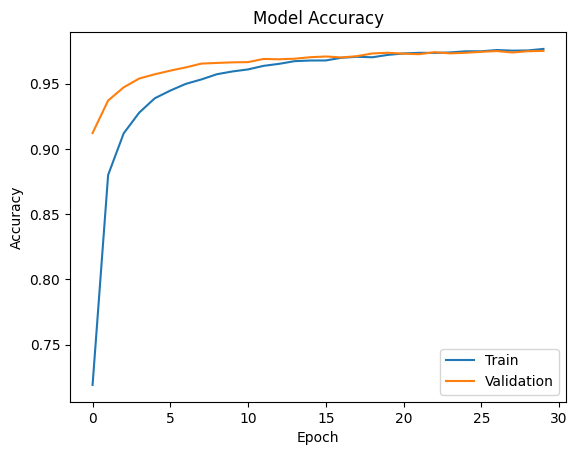

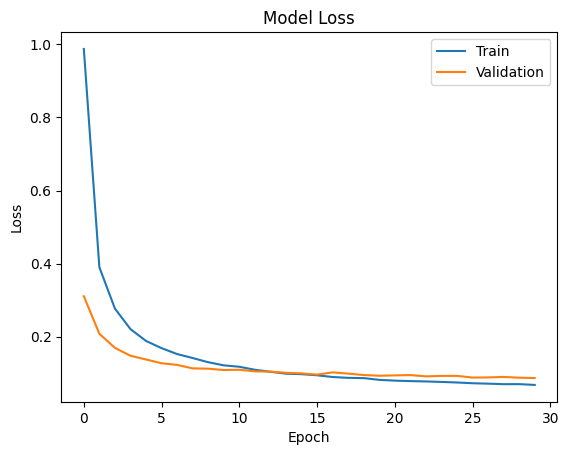

In [54]:
import matplotlib.pyplot as plt

# ===== ACCURACY =====
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# ===== LOSS =====
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [5]:
import tensorflow as tf
model = tf.keras.models.load_model("best_model.keras")

Found 3503 images belonging to 38 classes.
110/110 ━━━━━━━━━━━━━━━━━━━━ 39s 358ms/step
Validation Accuracy: 0.9492
Validation F1 Score: 0.9492

Accuracy cho từng lớp:
Lớp Apple___Apple_scab: 1.0000
Lớp Apple___Black_rot: 1.0000
Lớp Apple___Cedar_apple_rust: 0.9318
Lớp Apple___healthy: 0.9900
Lớp Blueberry___healthy: 0.9667
Lớp Cherry_(including_sour)___Powdery_mildew: 0.9881
Lớp Cherry_(including_sour)___healthy: 1.0000
Lớp Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0.9268
Lớp Corn_(maize)___Common_rust_: 1.0000
Lớp Corn_(maize)___Northern_Leaf_Blight: 1.0000
Lớp Corn_(maize)___healthy: 1.0000
Lớp Grape___Black_rot: 0.9787
Lớp Grape___Esca_(Black_Measles): 0.9896
Lớp Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1.0000
Lớp Grape___healthy: 1.0000
Lớp Orange___Haunglongbing_(Citrus_greening): 0.9900
Lớp Peach___Bacterial_spot: 1.0000
Lớp Peach___healthy: 0.8953
Lớp Pepper,_bell___Bacterial_spot: 1.0000
Lớp Pepper,_bell___healthy: 0.8485
Lớp Potato___Early_blight: 1.0000
Lớp Potat

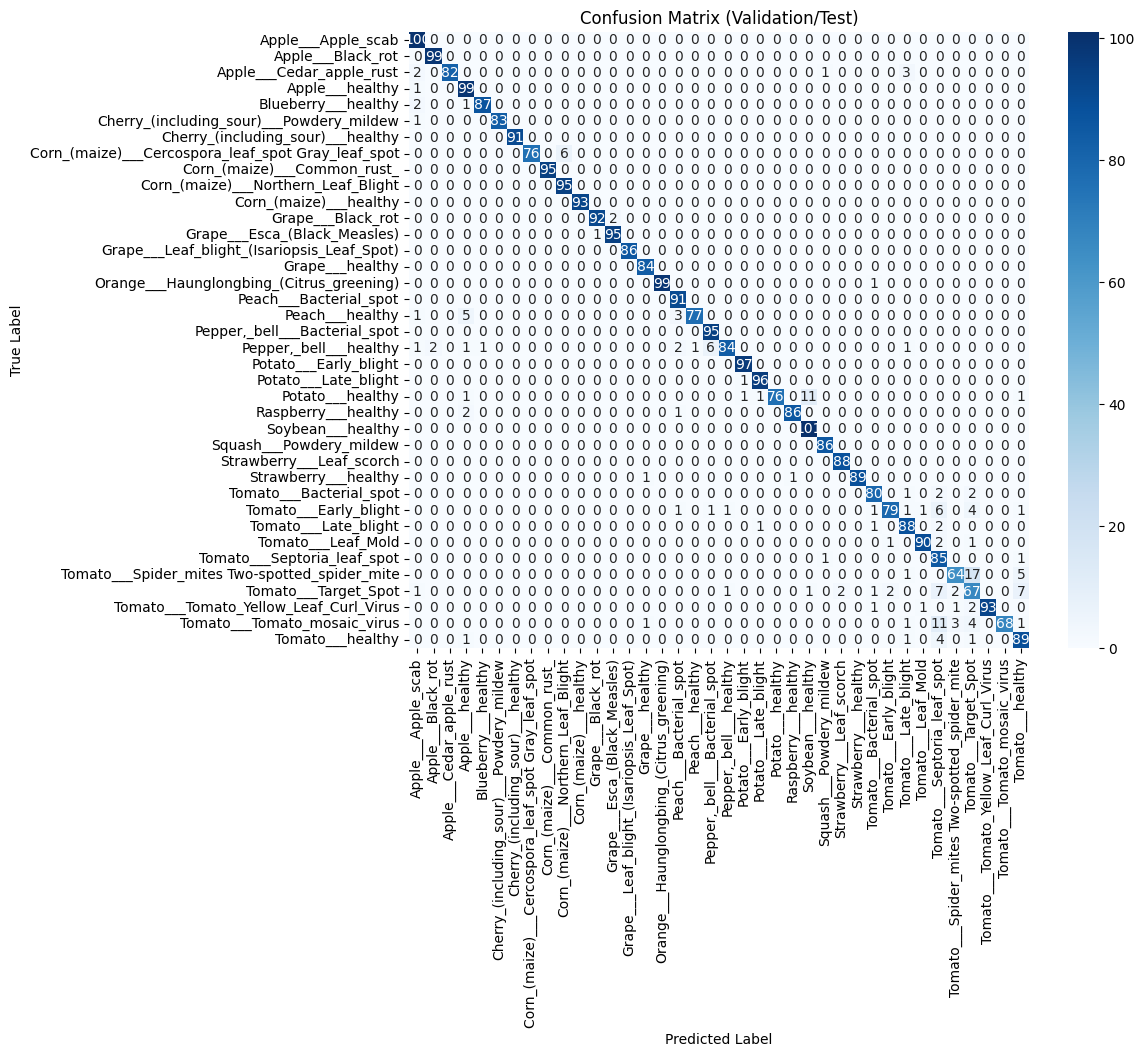

In [7]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import matplotlib.pyplot as plt

# =========================
DATA_DIR = "./valid"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.2
# =========================

train_datagen = ImageDataGenerator(
    validation_split=VAL_SPLIT,
    preprocessing_function=preprocess_input
)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# =========================
# Dự đoán
# =========================
Y_true = val_gen.classes
Y_pred_probs = model.predict(val_gen)
Y_pred = np.argmax(Y_pred_probs, axis=1)

# =========================
# Accuracy & F1
# =========================
acc = accuracy_score(Y_true, Y_pred)
f1 = f1_score(Y_true, Y_pred, average='weighted')

print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# =========================
# Confusion matrix (PHẢI TẠO TRƯỚC)
# =========================
cm = confusion_matrix(Y_true, Y_pred)
class_names = list(val_gen.class_indices.keys())

# =========================
# Accuracy cho từng lớp
# =========================
class_acc = cm.diagonal() / cm.sum(axis=1)

print("\nAccuracy cho từng lớp:")
for i, acc_i in enumerate(class_acc):
    print(f"Lớp {class_names[i]}: {acc_i:.4f}")

# =========================
# Vẽ confusion matrix
# =========================
plt.figure(figsize=(10, 8))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=class_names,
    yticklabels=class_names
)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation/Test)")
plt.show()


In [ ]:
from tensorflow.keras.utils import load_img, img_to_array

def predict_image(model, img_path, class_names):
    img = load_img(img_path, target_size=img_size)
    img = img_to_array(img)
    img = tf.expand_dims(img, axis=0)

    preds = model.predict(img)
    idx = np.argmax(preds)
    conf = np.max(preds)

    return class_names[idx], conf

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Dự đoán: Tomato___Septoria_leaf_spot (98.06%)


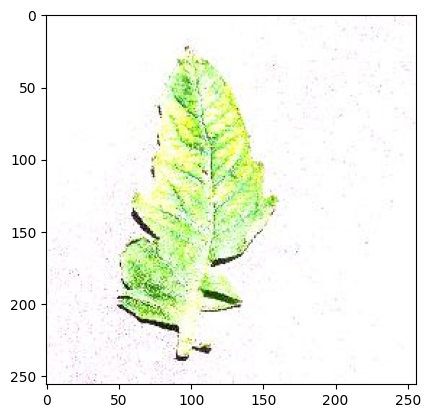

In [16]:
# Đường dẫn ảnh cần test
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

img_path = "./data/bright_images/Tomato___Tomato_mosaic_virus/0a7cc59f-b2b0-4201-9c4a-d91eca5c03a3___PSU_CG 2230_newPixel25.JPG"
label, conf = predict_image(model, img_path, class_names)
plt.imshow(image.load_img(img_path))
print(f"Dự đoán: {label} ({conf:.2%})")

Dự đoán sai (đúng loại lá, chưa đúng bệnh)

In [12]:
model = tf.keras.models.load_model("best_model.keras")

In [14]:
fine_tune_at = int(len(base_model.layers) * 0.7)

for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

for layer in base_model.layers[fine_tune_at:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

In [15]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
checkpoint = ModelCheckpoint(
    "best_model_tunning.keras",
    save_best_only=True,
    monitor="val_loss",
    mode="min",
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=3,
    restore_best_weights=True,
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=3,
    min_lr=1e-5,
)
history = model.fit(
    train_ds_aug,
    validation_data=valid_ds,
    epochs=20,
    callbacks=[checkpoint, early_stop, reduce_lr]
)

Epoch 1/20
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1274s 594ms/step - accuracy: 0.9778 - loss: 0.0659 - val_accuracy: 0.9751 - val_loss: 0.0872 - learning_rate: 1.0000e-05
Epoch 2/20
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1272s 595ms/step - accuracy: 0.9786 - loss: 0.0625 - val_accuracy: 0.9748 - val_loss: 0.0874 - learning_rate: 1.0000e-05
Epoch 3/20
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1328s 621ms/step - accuracy: 0.9788 - loss: 0.0634 - val_accuracy: 0.9748 - val_loss: 0.0877 - learning_rate: 1.0000e-05
Epoch 4/20
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1396s 653ms/step - accuracy: 0.9787 - loss: 0.0633 - val_accuracy: 0.9747 - val_loss: 0.0871 - learning_rate: 1.0000e-05
Epoch 5/20
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1376s 644ms/step - accuracy: 0.9786 - loss: 0.0622 - val_accuracy: 0.9752 - val_loss: 0.0865 - learning_rate: 1.0000e-05
Epoch 6/20
2137/2137 ━━━━━━━━━━━━━━━━━━━━ 1408s 659ms/step - accuracy: 0.9791 - loss: 0.0616 - val_accuracy: 0.9753 - val_loss: 0.0869 - learning_rate: 1.0000e-05
Epoch 7/20
2137/2137 ━

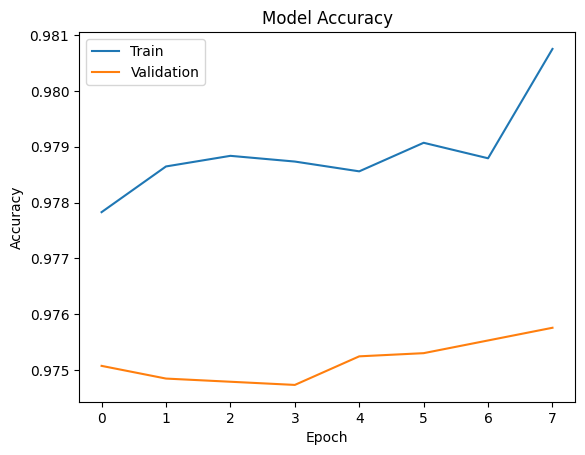

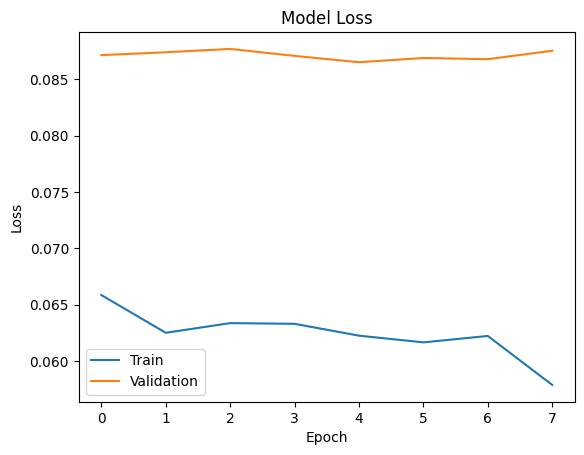

In [17]:
import matplotlib.pyplot as plt

# ===== ACCURACY =====
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

# ===== LOSS =====
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()


In [18]:
model = tf.keras.models.load_model("best_model_tunning.keras")

Found 5257 images belonging to 38 classes.
165/165 ━━━━━━━━━━━━━━━━━━━━ 76s 458ms/step
Validation Accuracy: 0.9502
Validation F1 Score: 0.9501

Accuracy cho từng lớp:
Lớp Apple___Apple_scab: 1.0000
Lớp Apple___Black_rot: 1.0000
Lớp Apple___Cedar_apple_rust: 0.9318
Lớp Apple___healthy: 0.9900
Lớp Blueberry___healthy: 0.9667
Lớp Cherry_(including_sour)___Powdery_mildew: 0.9881
Lớp Cherry_(including_sour)___healthy: 1.0000
Lớp Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot: 0.9390
Lớp Corn_(maize)___Common_rust_: 1.0000
Lớp Corn_(maize)___Northern_Leaf_Blight: 0.9684
Lớp Corn_(maize)___healthy: 1.0000
Lớp Grape___Black_rot: 0.9894
Lớp Grape___Esca_(Black_Measles): 0.9896
Lớp Grape___Leaf_blight_(Isariopsis_Leaf_Spot): 1.0000
Lớp Grape___healthy: 1.0000
Lớp Orange___Haunglongbing_(Citrus_greening): 0.9900
Lớp Peach___Bacterial_spot: 1.0000
Lớp Peach___healthy: 0.9070
Lớp Pepper,_bell___Bacterial_spot: 0.9895
Lớp Pepper,_bell___healthy: 0.8485
Lớp Potato___Early_blight: 1.0000
Lớp Potat

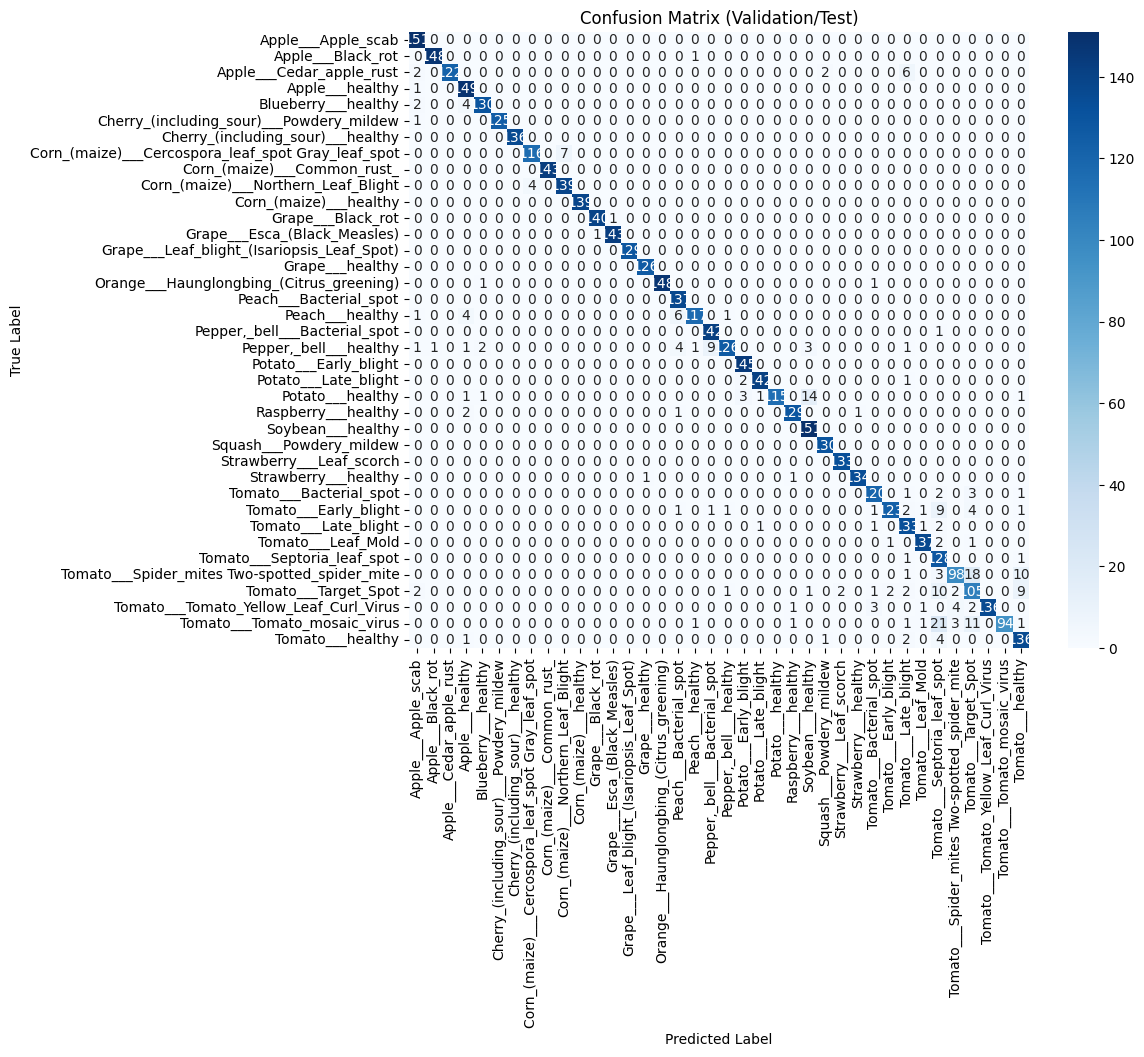

In [20]:
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
import matplotlib.pyplot as plt

# =========================
DATA_DIR = "./valid"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
VAL_SPLIT = 0.3
# =========================
# Tạo validation generator
train_datagen = ImageDataGenerator(validation_split=VAL_SPLIT, preprocessing_function=preprocess_input)

val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)
Y_true = val_gen.classes
Y_pred_probs = model.predict(val_gen)
Y_pred = np.argmax(Y_pred_probs, axis=1)
# =========================
# Tính accuracy và F1 score
# =========================
acc = accuracy_score(Y_true, Y_pred)
f1 = f1_score(Y_true, Y_pred, average='weighted')
print(f"Validation Accuracy: {acc:.4f}")
print(f"Validation F1 Score: {f1:.4f}")

# =========================
# Accuracy cho từng lớp
# =========================
class_acc = cm.diagonal() / cm.sum(axis=1)

print("\nAccuracy cho từng lớp:")
for i, acc_i in enumerate(class_acc):
    print(f"Lớp {class_names[i]}: {acc_i:.4f}")

# =========================
# Ma trận nhầm lẫn
# =========================
class_names = list(val_gen.class_indices.keys())

cm = confusion_matrix(Y_true, Y_pred)

plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Validation/Test)")
plt.show()

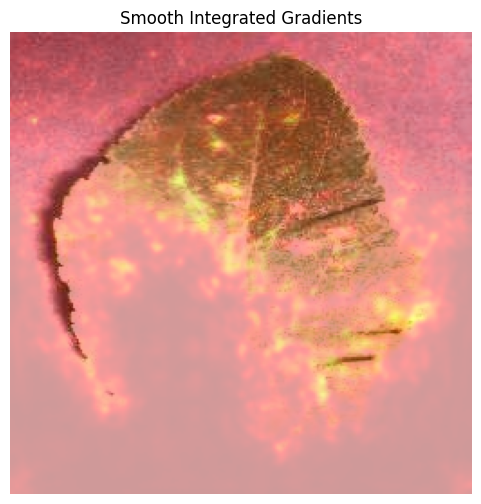

In [22]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# =========================
# Load & preprocess image
# =========================
def load_image(img_path, img_size=(224,224)):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.expand_dims(img, axis=0)
    img = tf.keras.applications.mobilenet_v3.preprocess_input(img)
    return img

# =========================
# Integrated Gradients
# =========================
def integrated_gradients(
    model,
    image,
    target_class_idx,
    baseline=None,
    steps=50
):
    if baseline is None:
        baseline = tf.zeros_like(image)

    alphas = tf.linspace(0.0, 1.0, steps)
    integrated_grads = tf.zeros_like(image)

    for alpha in alphas:
        with tf.GradientTape() as tape:
            interpolated = baseline + alpha * (image - baseline)
            tape.watch(interpolated)
            preds = model(interpolated)
            loss = preds[:, target_class_idx]

        grads = tape.gradient(loss, interpolated)
        integrated_grads += grads

    integrated_grads /= steps
    integrated_grads *= (image - baseline)
    return integrated_grads

# =========================
# Smooth Integrated Gradients
# =========================
def smooth_integrated_gradients(
    model,
    image,
    target_class_idx,
    baseline=None,
    steps=50,
    n_samples=25,
    noise_sigma=0.08
):
    if baseline is None:
        baseline = tf.zeros_like(image)

    smooth_ig = tf.zeros_like(image)

    for _ in range(n_samples):
        noise = tf.random.normal(image.shape, mean=0.0, stddev=noise_sigma)
        noisy_image = image + noise

        ig = integrated_gradients(
            model=model,
            image=noisy_image,
            target_class_idx=target_class_idx,
            baseline=baseline,
            steps=steps
        )

        smooth_ig += ig

    smooth_ig /= n_samples
    return smooth_ig

# =========================
# Visualization
# =========================
def visualize_ig(ig, img_path):
    ig = tf.reduce_mean(tf.abs(ig), axis=-1)[0]
    ig = ig.numpy()
    ig = ig / (ig.max() + 1e-8)

    # Smooth heatmap (optional but recommended)
    ig = cv2.GaussianBlur(ig, (7,7), 0)

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    ig = cv2.resize(ig, (img.shape[1], img.shape[0]))

    heatmap = np.uint8(255 * ig)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    overlay = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(6,6))
    plt.imshow(overlay)
    plt.axis("off")
    plt.title("Smooth Integrated Gradients")
    plt.show()

# =========================
# RUN
# =========================
img_path = "./data1/bright_images/Apple___Cedar_apple_rust/2ac8d689-f30a-4eee-a856-86c92f8dcbd2___FREC_C.Rust 3952_newPixel25.JPG"

image = load_image(img_path)

preds = model(image)
class_idx = tf.argmax(preds[0]).numpy()

baseline = tf.ones_like(image) * 0.5  # gray baseline

ig = smooth_integrated_gradients(
    model=model,
    image=image,
    target_class_idx=class_idx,
    baseline=baseline,
    steps=80,
    n_samples=25,
    noise_sigma=0.08
)

visualize_ig(ig, img_path)


In [50]:
import os
import numpy as np

data_dir = "./train_clean1"

image_paths = []
labels = []

class_names = sorted(os.listdir(data_dir))

for label, class_name in enumerate(class_names):
    class_dir = os.path.join(data_dir, class_name)
    for fname in os.listdir(class_dir):
        image_paths.append(os.path.join(class_dir, fname))
        labels.append(label)

image_paths = np.array(image_paths)
labels = np.array(labels)

print("num_classes:", len(class_names))

num_classes: 38


In [53]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
acc_scores = []

In [54]:
import tensorflow as tf

def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224,224))
    img = img / 255.0
    return img, label


In [ ]:
for fold, (train_idx, val_idx) in enumerate(skf.split(image_paths, labels)):
    print(f"\nFold {fold+1}")

    X_train, X_val = image_paths[train_idx], image_paths[val_idx]
    y_train, y_val = labels[train_idx], labels[val_idx]

    train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    # Load ảnh
    train_ds = train_ds.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)

    # Augmentation
    train_ds = train_ds.map(augment_train, num_parallel_calls=1)

    # Batch + Prefetch
    train_ds = train_ds.batch(32).prefetch(tf.data.AUTOTUNE)


    val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val))
    val_ds = val_ds.map(load_image).batch(32).prefetch(tf.data.AUTOTUNE)

    base_model = tf.keras.applications.MobileNetV3Large(
        input_shape=(224,224,3),
        include_top=False,
        weights="imagenet"
    )
    base_model.trainable = False

    model_cv = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation="relu"),
        tf.keras.layers.Dense(len(class_names), activation='softmax')
    ])

    model_cv.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    model_cv.fit(train_ds, epochs=5, verbose=0)

    loss, acc = model_cv.evaluate(val_ds, verbose=0)
    acc_scores.append(acc)

    print(f"Fold {fold+1} accuracy: {acc:.4f}")



Fold 1
